In [1]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from collections import Counter
import string
import emoji
from transformers import AutoModelForSequenceClassification
import torch
import seaborn as sns
import plotly.express as px
import nltk
import torch.nn.functional as F

from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # Change 'english' for other languages if needed

c:\Will\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

df_main = pd.read_csv("C://Will//ueh//complaints//complaints.csv", encoding='latin1')
print(df_main.shape)  # This will show (rows, columns)
#Missing value handling
df_main.isnull().sum()


(283215, 18)


Date received                        0
Product                              0
Sub-product                      20697
Issue                                0
Sub-issue                        58040
Consumer review narrative       199550
Company public response         198607
Company                              0
State                             1839
ZIP code                          1112
Tags                            256587
Consumer consent provided?      156227
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?              201652
Complaint ID                         0
dtype: int64

In [3]:
df_main = df_main.dropna(subset=['Consumer review narrative'])
df_main.isnull().sum()
 

Date received                       0
Product                             0
Sub-product                      8582
Issue                               0
Sub-issue                       22308
Consumer review narrative           0
Company public response         38190
Company                             0
State                             319
ZIP code                            1
Tags                            69917
Consumer consent provided?        139
Submitted via                       0
Date sent to company                0
Company response to consumer        0
Timely response?                    0
Consumer disputed?              53449
Complaint ID                        0
dtype: int64

In [4]:
df_sample = df_main.sample(n=2000, random_state=42)  # random_state để kết quả ổn định

# Xuất file CSV
output_file = "sample_2000.csv"
df_sample.to_csv(output_file, index=False, encoding='utf-8-sig')

In [5]:

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Remove stopwords
    text = " ".join(word for word in text.split() if word not in stop_words)
    
    # Remove emojis
    text = emoji.replace_emoji(text, replace="")
    
    # Remove extra spaces and numbers (optional)
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[0-9]+', '', text)  # Remove numbers
    text = re.sub(r'\b\w*xx{2,}\w*\b', '', text)
    
    return text.split()


In [6]:
df_main['processed_comsumer_review'] = df_main['Consumer review narrative'].astype(str).apply(preprocess_text)

In [7]:
df_label = pd.read_csv("C://Will//ueh//complaints//labeled_data.csv", encoding='latin1')
print(df_label.shape)

(2000, 3)


In [8]:
df_label['processed_comsumer_review'] = df_label['Consumer review narrative'].astype(str).apply(preprocess_text)

In [9]:
label_counts = df_label['displeasure_labeling'].value_counts()
print("Số lượng dữ liệu của mỗi nhãn:")
print(label_counts)

Số lượng dữ liệu của mỗi nhãn:
displeasure_labeling
5    1635
3     169
2     141
4      47
1       8
Name: count, dtype: int64


In [10]:
def map_label(label):
    if label in [1, 2]:
        return 'negative'
    elif label in [4, 5]:
        return 'positive'
    elif label == 3:
        return 'neutral'

df_label['displeasure_labeling'] = df_label['displeasure_labeling'].apply(map_label)

# Đếm số lượng dữ liệu của mỗi nhãn
label_counts = df_label['displeasure_labeling'].value_counts()
print("Số lượng dữ liệu của mỗi nhãn:")
print(label_counts)

Số lượng dữ liệu của mỗi nhãn:
displeasure_labeling
positive    1682
neutral      169
negative     149
Name: count, dtype: int64


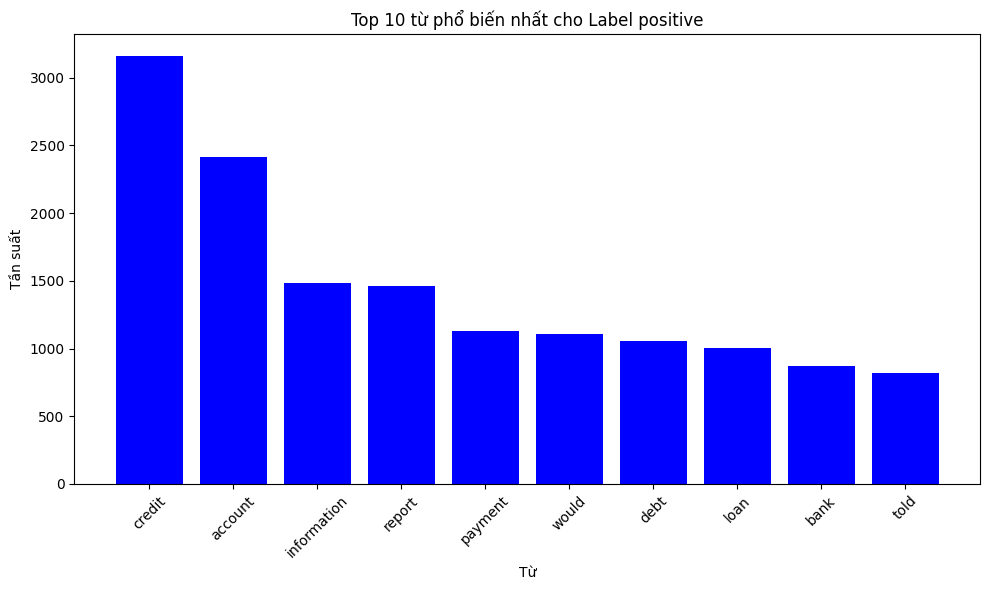

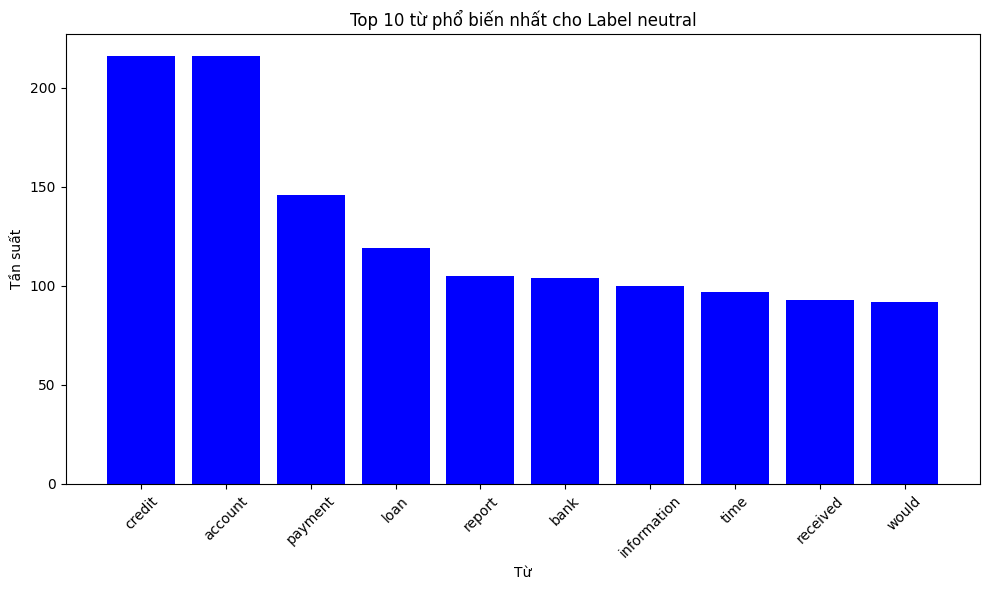

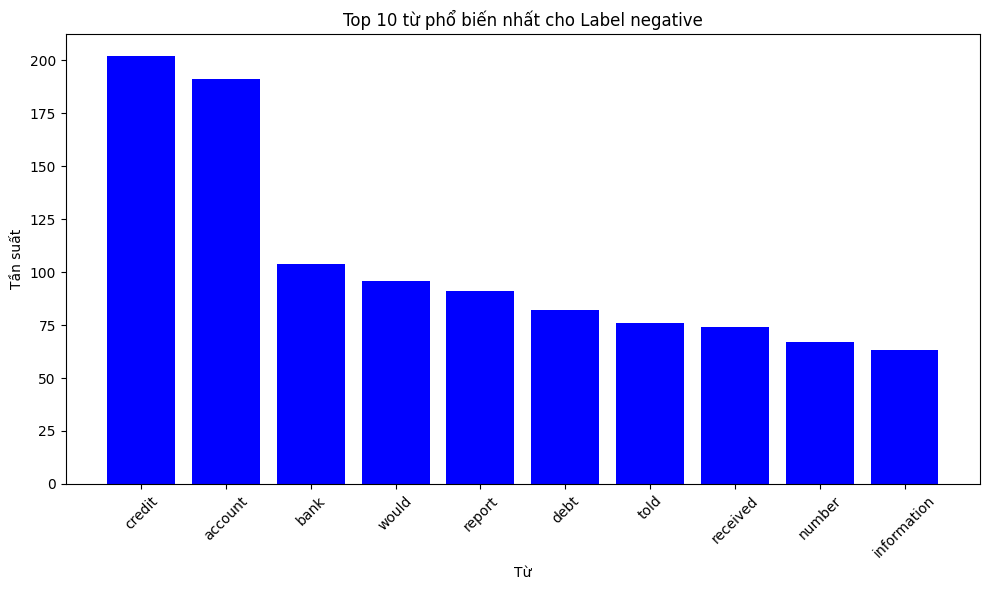

In [11]:

# Khởi tạo từ điển để lưu số lần xuất hiện của từ theo nhãn
word_counts_by_label = {}

# Duyệt qua từng nhãn và đếm từ
for label in df_label['displeasure_labeling'].unique():
    # Lấy tất cả các câu của nhãn hiện tại
    reviews = df_label[df_label['displeasure_labeling'] == label]['processed_comsumer_review']
    
    # Tokenize từ tất cả các câu thành danh sách từ
    words = []
    for review in reviews:
        if isinstance(review, list):
            review = ' '.join(review)

        tokens = nltk.word_tokenize(review.lower())  # Chuyển thành chữ thường và tokenize
        words.extend(tokens)
  

    # Đếm tần suất từ
    word_counts = Counter(words)

    # Lấy 100 từ xuất hiện nhiều nhất
    most_common_words = word_counts.most_common(100)

    # Lưu kết quả vào từ điển
    word_counts_by_label[label] = most_common_words

# Biểu diễn kết quả bằng biểu đồ cột
for label, words in word_counts_by_label.items():
    # Lấy từ và tần suất
    words_list, counts = zip(*words)

    # Tạo biểu đồ cột
    plt.figure(figsize=(10, 6))
    plt.bar(words_list[:10], counts[:10], color='blue')  # Hiển thị top 10 từ phổ biến nhất
    plt.title(f'Top 10 từ phổ biến nhất cho Label {label}')
    plt.xlabel('Từ')
    plt.ylabel('Tần suất')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [12]:
# Tách dữ liệu
X = df_label['processed_comsumer_review'].apply(lambda x: ' '.join(x))
y = df_label['displeasure_labeling']  


# Tách tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorize dữ liệu bằng Tfidf
tfidf = TfidfVectorizer(max_features=5000)  # Giới hạn số lượng từ đặc trưng
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

In [13]:
# Huấn luyện Logistic Regression cho dữ liệu TF-IDF
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

# Dự đoán và đánh giá
y_pred_lr = lr.predict(X_test_tfidf)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        30
     neutral       0.00      0.00      0.00        34
    positive       0.84      1.00      0.91       336

    accuracy                           0.84       400
   macro avg       0.28      0.33      0.30       400
weighted avg       0.71      0.84      0.77       400



c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Huấn luyện Random Forest cho dữ liệu TF-IDF
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)

# Dự đoán và đánh giá
y_pred_rf = rf.predict(X_test_tfidf)
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Report:
              precision    recall  f1-score   support

    negative       1.00      0.07      0.12        30
     neutral       0.00      0.00      0.00        34
    positive       0.84      1.00      0.92       336

    accuracy                           0.84       400
   macro avg       0.61      0.36      0.35       400
weighted avg       0.78      0.84      0.78       400



c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
from sklearn.svm import SVC

# Huấn luyện SVM cho dữ liệu TF-IDF
svm = SVC()
svm.fit(X_train_tfidf, y_train)

# Dự đoán và đánh giá
y_pred_svm = svm.predict(X_test_tfidf)
print("SVM Report:")
print(classification_report(y_test, y_pred_svm))

SVM Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        30
     neutral       0.00      0.00      0.00        34
    positive       0.84      1.00      0.91       336

    accuracy                           0.84       400
   macro avg       0.28      0.33      0.30       400
weighted avg       0.71      0.84      0.77       400



c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased") 


In [17]:

# Load a pre-trained model with a classification head
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)  # Adjust num_labels as needed


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load your model and move it to the selected device
model = model.to(device)


Using device: cuda


In [19]:
# test
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
 
from sklearn.preprocessing import LabelEncoder

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert y to numeric values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Modify Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=512, return_tensors="pt")
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to torch long tensor

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Re-create datasets
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)


# Step 4: Set Up Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Step 5: Trainer API for Training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Step 6: Train the Model
trainer.train()

# Step 7: Evaluate the Model
predictions = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), dim=1)

print("DistilBERT Classification Report:")
print(classification_report(y_test, y_pred))


c:\Will\.venv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  2%|▏         | 11/600 [00:02<01:43,  5.70it/s]

{'loss': 1.064, 'grad_norm': 4.609157562255859, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.05}


  4%|▎         | 21/600 [00:04<01:39,  5.84it/s]

{'loss': 1.0525, 'grad_norm': 4.532527923583984, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.1}


  5%|▌         | 31/600 [00:05<01:36,  5.88it/s]

{'loss': 0.9663, 'grad_norm': 5.222554683685303, 'learning_rate': 3e-06, 'epoch': 0.15}


  7%|▋         | 41/600 [00:07<01:33,  5.98it/s]

{'loss': 0.9093, 'grad_norm': 3.197728395462036, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.2}


  8%|▊         | 51/600 [00:09<01:30,  6.07it/s]

{'loss': 0.8016, 'grad_norm': 3.6573033332824707, 'learning_rate': 5e-06, 'epoch': 0.25}


 10%|█         | 61/600 [00:10<01:29,  6.04it/s]

{'loss': 0.7267, 'grad_norm': 2.9504172801971436, 'learning_rate': 6e-06, 'epoch': 0.3}


 12%|█▏        | 71/600 [00:12<01:29,  5.94it/s]

{'loss': 0.4484, 'grad_norm': 2.0207762718200684, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.35}


 14%|█▎        | 81/600 [00:14<01:23,  6.21it/s]

{'loss': 0.5589, 'grad_norm': 2.6895861625671387, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.4}


 15%|█▌        | 91/600 [00:15<01:25,  5.95it/s]

{'loss': 0.6503, 'grad_norm': 2.01604962348938, 'learning_rate': 9e-06, 'epoch': 0.45}


 17%|█▋        | 101/600 [00:17<01:23,  5.96it/s]

{'loss': 0.5665, 'grad_norm': 1.6685998439788818, 'learning_rate': 1e-05, 'epoch': 0.5}


 18%|█▊        | 111/600 [00:19<01:20,  6.11it/s]

{'loss': 0.4614, 'grad_norm': 2.7631759643554688, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.55}


 20%|██        | 121/600 [00:20<01:16,  6.23it/s]

{'loss': 0.4287, 'grad_norm': 2.056243658065796, 'learning_rate': 1.2e-05, 'epoch': 0.6}


 22%|██▏       | 131/600 [00:22<01:22,  5.68it/s]

{'loss': 0.6298, 'grad_norm': 1.5513617992401123, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.65}


 24%|██▎       | 141/600 [00:24<01:13,  6.29it/s]

{'loss': 0.6776, 'grad_norm': 2.1667749881744385, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.7}


 25%|██▌       | 151/600 [00:25<01:12,  6.16it/s]

{'loss': 0.5409, 'grad_norm': 7.052372455596924, 'learning_rate': 1.5e-05, 'epoch': 0.75}


 27%|██▋       | 161/600 [00:27<01:14,  5.87it/s]

{'loss': 0.6355, 'grad_norm': 1.9205234050750732, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.8}


 28%|██▊       | 171/600 [00:28<01:10,  6.11it/s]

{'loss': 0.5432, 'grad_norm': 2.038508653640747, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.85}


 30%|███       | 181/600 [00:30<01:07,  6.16it/s]

{'loss': 0.6884, 'grad_norm': 3.8296916484832764, 'learning_rate': 1.8e-05, 'epoch': 0.9}


 32%|███▏      | 191/600 [00:32<01:08,  6.00it/s]

{'loss': 0.6228, 'grad_norm': 2.6680784225463867, 'learning_rate': 1.9e-05, 'epoch': 0.95}


 33%|███▎      | 200/600 [00:33<01:04,  6.16it/s]

{'loss': 0.4184, 'grad_norm': 1.6991444826126099, 'learning_rate': 2e-05, 'epoch': 1.0}


                                                 
 34%|███▎      | 201/600 [00:36<05:46,  1.15it/s]

{'eval_loss': 0.5413597822189331, 'eval_runtime': 2.3309, 'eval_samples_per_second': 171.61, 'eval_steps_per_second': 21.451, 'epoch': 1.0}


 35%|███▌      | 211/600 [00:37<01:12,  5.36it/s]

{'loss': 0.6634, 'grad_norm': 1.845065951347351, 'learning_rate': 2.1e-05, 'epoch': 1.05}


 37%|███▋      | 221/600 [00:39<01:00,  6.26it/s]

{'loss': 0.5626, 'grad_norm': 1.8337064981460571, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.1}


 38%|███▊      | 231/600 [00:41<01:02,  5.86it/s]

{'loss': 0.7424, 'grad_norm': 3.4527394771575928, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.15}


 40%|████      | 241/600 [00:42<00:58,  6.10it/s]

{'loss': 0.5757, 'grad_norm': 2.0331149101257324, 'learning_rate': 2.4e-05, 'epoch': 1.2}


 42%|████▏     | 251/600 [00:44<00:56,  6.23it/s]

{'loss': 0.5496, 'grad_norm': 2.6859891414642334, 'learning_rate': 2.5e-05, 'epoch': 1.25}


 44%|████▎     | 261/600 [00:46<00:54,  6.24it/s]

{'loss': 0.4324, 'grad_norm': 3.44830322265625, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.3}


 45%|████▌     | 271/600 [00:47<00:53,  6.14it/s]

{'loss': 0.5948, 'grad_norm': 5.496638298034668, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.35}


 47%|████▋     | 281/600 [00:49<00:51,  6.21it/s]

{'loss': 0.439, 'grad_norm': 1.821618914604187, 'learning_rate': 2.8000000000000003e-05, 'epoch': 1.4}


 48%|████▊     | 291/600 [00:50<00:50,  6.13it/s]

{'loss': 0.5382, 'grad_norm': 3.5182647705078125, 'learning_rate': 2.9e-05, 'epoch': 1.45}


 50%|█████     | 301/600 [00:52<00:51,  5.77it/s]

{'loss': 0.5411, 'grad_norm': 2.3924264907836914, 'learning_rate': 3e-05, 'epoch': 1.5}


 52%|█████▏    | 311/600 [00:54<00:49,  5.80it/s]

{'loss': 0.3692, 'grad_norm': 1.1503379344940186, 'learning_rate': 3.1e-05, 'epoch': 1.55}


 54%|█████▎    | 321/600 [00:56<00:45,  6.09it/s]

{'loss': 0.6119, 'grad_norm': 1.4472047090530396, 'learning_rate': 3.2000000000000005e-05, 'epoch': 1.6}


 55%|█████▌    | 331/600 [00:57<00:44,  6.09it/s]

{'loss': 0.4595, 'grad_norm': 1.5260734558105469, 'learning_rate': 3.3e-05, 'epoch': 1.65}


 57%|█████▋    | 341/600 [00:59<00:41,  6.22it/s]

{'loss': 0.5929, 'grad_norm': 3.43998384475708, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.7}


 58%|█████▊    | 351/600 [01:00<00:40,  6.13it/s]

{'loss': 0.8856, 'grad_norm': 1.4493398666381836, 'learning_rate': 3.5e-05, 'epoch': 1.75}


 60%|██████    | 361/600 [01:02<00:39,  6.02it/s]

{'loss': 0.622, 'grad_norm': 3.049403429031372, 'learning_rate': 3.6e-05, 'epoch': 1.8}


 62%|██████▏   | 371/600 [01:04<00:37,  6.06it/s]

{'loss': 0.6208, 'grad_norm': 1.6281013488769531, 'learning_rate': 3.7e-05, 'epoch': 1.85}


 64%|██████▎   | 381/600 [01:05<00:35,  6.10it/s]

{'loss': 0.4736, 'grad_norm': 5.64438533782959, 'learning_rate': 3.8e-05, 'epoch': 1.9}


 65%|██████▌   | 391/600 [01:07<00:34,  6.07it/s]

{'loss': 0.3928, 'grad_norm': 1.49601149559021, 'learning_rate': 3.9000000000000006e-05, 'epoch': 1.95}


 67%|██████▋   | 400/600 [01:08<00:32,  6.12it/s]

{'loss': 0.5155, 'grad_norm': 2.9341869354248047, 'learning_rate': 4e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 401/600 [01:11<02:55,  1.13it/s]

{'eval_loss': 0.5731685161590576, 'eval_runtime': 2.3952, 'eval_samples_per_second': 166.998, 'eval_steps_per_second': 20.875, 'epoch': 2.0}


 68%|██████▊   | 411/600 [01:13<00:35,  5.39it/s]

{'loss': 0.4787, 'grad_norm': 1.5419000387191772, 'learning_rate': 4.1e-05, 'epoch': 2.05}


 70%|███████   | 421/600 [01:14<00:29,  6.05it/s]

{'loss': 0.8233, 'grad_norm': 1.8270844221115112, 'learning_rate': 4.2e-05, 'epoch': 2.1}


 72%|███████▏  | 431/600 [01:16<00:28,  5.91it/s]

{'loss': 0.6247, 'grad_norm': 1.4199401140213013, 'learning_rate': 4.3e-05, 'epoch': 2.15}


 74%|███████▎  | 441/600 [01:18<00:27,  5.84it/s]

{'loss': 0.6079, 'grad_norm': 1.8927079439163208, 'learning_rate': 4.4000000000000006e-05, 'epoch': 2.2}


 75%|███████▌  | 451/600 [01:19<00:24,  6.15it/s]

{'loss': 0.4988, 'grad_norm': 1.2463042736053467, 'learning_rate': 4.5e-05, 'epoch': 2.25}


 77%|███████▋  | 461/600 [01:21<00:22,  6.16it/s]

{'loss': 0.608, 'grad_norm': 1.5032010078430176, 'learning_rate': 4.600000000000001e-05, 'epoch': 2.3}


 78%|███████▊  | 471/600 [01:23<00:20,  6.22it/s]

{'loss': 0.5868, 'grad_norm': 2.8932912349700928, 'learning_rate': 4.7e-05, 'epoch': 2.35}


 80%|████████  | 481/600 [01:24<00:20,  5.82it/s]

{'loss': 0.5129, 'grad_norm': 1.4876388311386108, 'learning_rate': 4.8e-05, 'epoch': 2.4}


 82%|████████▏ | 491/600 [01:26<00:17,  6.15it/s]

{'loss': 0.4977, 'grad_norm': 2.223311185836792, 'learning_rate': 4.9e-05, 'epoch': 2.45}


 83%|████████▎ | 500/600 [01:27<00:16,  6.06it/s]

{'loss': 0.5034, 'grad_norm': 1.3919199705123901, 'learning_rate': 5e-05, 'epoch': 2.5}


 85%|████████▌ | 511/600 [01:30<00:14,  5.95it/s]

{'loss': 0.4334, 'grad_norm': 1.721459984779358, 'learning_rate': 4.5e-05, 'epoch': 2.55}


 87%|████████▋ | 521/600 [01:32<00:13,  5.88it/s]

{'loss': 0.4737, 'grad_norm': 2.0696141719818115, 'learning_rate': 4e-05, 'epoch': 2.6}


 88%|████████▊ | 531/600 [01:33<00:11,  5.81it/s]

{'loss': 0.5874, 'grad_norm': 2.3335788249969482, 'learning_rate': 3.5e-05, 'epoch': 2.65}


 90%|█████████ | 541/600 [01:35<00:09,  5.93it/s]

{'loss': 0.5311, 'grad_norm': 1.6624451875686646, 'learning_rate': 3e-05, 'epoch': 2.7}


 92%|█████████▏| 551/600 [01:37<00:08,  6.09it/s]

{'loss': 0.6646, 'grad_norm': 2.5304150581359863, 'learning_rate': 2.5e-05, 'epoch': 2.75}


 94%|█████████▎| 561/600 [01:38<00:06,  6.08it/s]

{'loss': 0.6515, 'grad_norm': 2.518745183944702, 'learning_rate': 2e-05, 'epoch': 2.8}


 95%|█████████▌| 571/600 [01:40<00:04,  6.01it/s]

{'loss': 0.4833, 'grad_norm': 1.611892819404602, 'learning_rate': 1.5e-05, 'epoch': 2.85}


 97%|█████████▋| 581/600 [01:42<00:03,  6.12it/s]

{'loss': 0.2759, 'grad_norm': 1.6368907690048218, 'learning_rate': 1e-05, 'epoch': 2.9}


 98%|█████████▊| 591/600 [01:43<00:01,  6.15it/s]

{'loss': 0.5974, 'grad_norm': 1.4352902173995972, 'learning_rate': 5e-06, 'epoch': 2.95}


100%|██████████| 600/600 [01:45<00:00,  6.20it/s]

{'loss': 0.6531, 'grad_norm': 1.6395504474639893, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 600/600 [01:48<00:00,  5.54it/s]


{'eval_loss': 0.5467272996902466, 'eval_runtime': 2.3751, 'eval_samples_per_second': 168.416, 'eval_steps_per_second': 21.052, 'epoch': 3.0}
{'train_runtime': 108.2242, 'train_samples_per_second': 44.352, 'train_steps_per_second': 5.544, 'train_loss': 0.5944530967871348, 'epoch': 3.0}


100%|██████████| 50/50 [00:02<00:00, 21.47it/s]

DistilBERT Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        30
           1       0.00      0.00      0.00        34
           2       0.84      1.00      0.91       336

    accuracy                           0.84       400
   macro avg       0.61      0.34      0.33       400
weighted avg       0.78      0.84      0.77       400




c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Will\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
def predict_sentiment(text, tokenizer, model, device):
    tokens = tokenizer.encode(text,max_length=512, return_tensors='pt').to(device)
    result = model(tokens)
    sentiment = int(torch.argmax(result.logits))+1
    return sentiment

In [30]:
# Áp dụng lên cột văn bản trong df_main
df_main['predicted_label'] = df_main['processed_comsumer_review'].astype(str).apply(
    lambda x: predict_sentiment(x, tokenizer, model, device)
)

# Kiểm tra kết quả
print(df_main[['Consumer review narrative', 'predicted_label']].head())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


                            Consumer review narrative  predicted_label
1   Original Debt is from XXXX in the amount of {$...                3
76                                               nice                3
77  I am writing to delete the following informati...                3
93  I, XXXX XXXX XXXX, an avid consumer that knows...                3
98  I just called about the fact that Homebridge k...                3
